# 4.1

In [44]:
import imageio
img_arr=imageio.imread('bobby.jpg')
img_arr.shape

(720, 1280, 3)

파이토치 모듈은 텐서가 채널X높이X너비 형태로 되어있어야 한다.

배치를 사용한다면 배치크기x채널X높이X너비

In [45]:
import torch

img=torch.from_numpy(img_arr)
out=img.permute(2,0,1)
#out과 img저장공간이 같으며 텐서레벨에서 크기와 스트라이드 정보가 바뀌었기 때문에 img값이 바뀌면 out값도 바뀜

In [46]:
batch_size=3
batch=torch.zeros(batch_size,3,256,256,dtype=torch.uint8)

In [47]:
import os
data_dir='cats/'
filenames=[name for name in os.listdir(data_dir) if os.path.splitext(name)[-1]=='png']
for i,filename in enumerate(filenames):
  img_arr=imageio.imread(os.path.join(data_dir,filename))
  img_t=torch.from_numpy(img_arr)
  img_t=img_t.permute(2,0,1)
  img_t=img_t[:3] #투명 알파채널까지 있는 이미도 있는 경우가 있음 RGB만 사용할 예정이므로 첫 세개 채널만.
  batch[i]=img_t


신경망은 입력값이 0 ~ 1이거나 -1 ~ 1일때 훈련성능이 가장 좋은 특징을 띤다. 따라서 대부분의 경우 텐서를 부동소수점으로 캐스팅하고 픽셀값을 정규화한다.

In [48]:
#단순하게 픽셀값을 부호없는 8비트의 정수의 최댓값인 255로 나눠 정규화 진행
batch=batch.float()
batch/=255.0

In [49]:
#입력 데이터의 평균과 표준편차를 구해 정규화 진행
n_channels=batch.shape[1] #지금 배치사이즈 3x3x256x256
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

# 4.2

In [50]:
import imageio

dir_path = "data/"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%)99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 40/99  (40.4%)99/99  (100.0%)


(99, 512, 512)

In [51]:
#채널차원을 위한 공간필요
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)

vol.shape

torch.Size([1, 99, 512, 512])

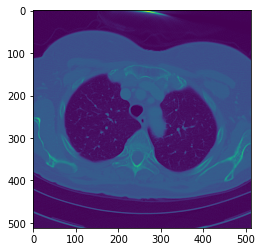

In [52]:
import matplotlib.pyplot as plt

plt.imshow(vol_arr[20])

# 4.3 와인데이터

In [53]:
import numpy as np
import torch
import csv
wine_path = "winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [54]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))

wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [55]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [56]:
#점수 표현하기
data = wineq[:, :-1] # 마지막열 제거
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [57]:
target = wineq[:, -1] # 마지막열
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

In [58]:
target = wineq[:, -1].long() #카테고리 데이터 정수벡터로 레이블처리
target

tensor([6, 6, 6,  ..., 6, 7, 6])

In [59]:
#카테고리 데이터 원핫인코딩 이용(해당하는 원소하나만 1로 설정하고 나머지는 0으로)
target_onehot = torch.zeros(target.shape[0], 10)

#scatter 함수 인자
#뒤에 오는 두개의 인자가 따라야 하는 차원을 명세
#원핫으로 인코딩할 요소를 가리키는 인덱스가 들어있는 텐서
#원핫 인코딩할 원소가 들어있는 텐서 혹은 단일 스칼라 이 경우엔 1

target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
#각행에서 대상이 되는 레이블의 인덱스를 취한 후 열 인덱스 값으로 사용해서 해당 항목의 값을 1.0으로

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [60]:
data_mean = torch.mean(data, dim=0) #피처별 평균
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [62]:
data_var = torch.var(data, dim=0) #피처별 분산
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In [63]:
#정규화 진행
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
          1.3422e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])

In [64]:
#임계값을 정해 쉽게 구별하기
bad_indexes = target <= 3 # 점수가 3이하인 열을 거르기
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(20))

In [65]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

In [67]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)] 
good_data = data[target >= 7]

bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

# 나쁜와인은 sulfur dioxide가 높은 편이고, 좋고 나쁜을 판단하기위한 대강의 평가기준으로 total sulfur dioxide를 임계값으로 사용해도 될거같다.

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


In [71]:
# total sulfur dioxide에서 앞서 계산해놓은 중앙점보다 낮은 인덱스만 가져오기
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)

predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

In [69]:
#torch.lt는 요소비교에 사용됨(less than)
a = torch.Tensor([[1, 2], [3, 4]])
b = torch.Tensor([[1, 1], [4, 4]])
torch.lt(a, b)

tensor([[False, False],
        [ True, False]])

In [72]:
#예측이 맞는지 확인하기 위해 실제로 좋은 와인의 인덱스를 뽑기
actual_indexes = target > 5

actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(3258))

In [73]:
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()

n_matches, n_matches / n_predicted, n_matches / n_actual

(2018, 0.74000733406674, 0.6193984039287906)

# 4.4 시계열데이터

In [74]:
bikes_numpy = np.loadtxt(
    "hour-fixed.csv", 
    dtype=np.float32, 
    delimiter=",", 
    skiprows=1, 
    converters={1: lambda x: float(x[8:10])}) # yyyy-mm-dd이런식으로 되어있는 첫번째 열의 일자문자열을 숫자로 변환
bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

In [76]:
bikes.shape, bikes.stride()
#17520시간에 17개열

(torch.Size([17520, 17]), (17, 1))

In [77]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1]) #-1은 남은 차원과 거기에 들어있는 요소를 다 합친것을 의미하는 플레이스홀더로 사용 
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

In [78]:
#전치를 통해 NxCxL:C개의 채널을 가진 하루를 L시간으로 나눈 N개의 연속된값
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

In [84]:
#하루시간대만 먼저 생각해보기
first_day=bikes[:24].long() #shape:(24,17)
weather_onehot = torch.zeros(first_day.shape[0], 4) #날씨상태 총 4개있음.
first_day[:,9] #9번째 열에 날씨상태가 있음

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2])

In [85]:
#날씨 상태를 원핫인코딩으로 변환
weather_onehot.scatter_(
    dim=1, 
    index=first_day[:,9].unsqueeze(1).long() - 1, #날씨값이 1부터 4인데 색인은 0에서 시작해서 1빼줌
    value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

In [89]:
#원핫 인코딩한 행렬을 해당하는 각 행에 cat함수 이용해 추가.
#첫번째 행을 보면, 9열은 날씨, 10번째부터 4개열은 그에 해당하는 원핫인코딩임을 확인할수 있음
torch.cat((bikes[:24], weather_onehot), 1)[1]

tensor([ 2.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  0.0000,  6.0000,
         0.0000,  1.0000,  0.2200,  0.2727,  0.8000,  0.0000,  8.0000, 32.0000,
        40.0000,  1.0000,  0.0000,  0.0000,  0.0000])

In [90]:
#이제 전체 데이터에 적용해보기
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4,
                                   daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [91]:
daily_weather_onehot.scatter_(
    1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [92]:
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

In [93]:
#변수를 0~1사이의 사이로 범위변경하는것도 가능
temp = daily_bikes[:, 10, :] #열번째열
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - temp_min)
                         / (temp_max - temp_min))

In [94]:
#표준정규분포를 따르게도 가능
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp))
                         / torch.std(temp))

# 4.5 텍스트표현

문자(char) 원핫인코딩은 문자의 종류수가 벡터의 크기가 되어 각 문자가 이 크기의 벡터로 표현된다.

단어단위로는 임베딩 매트릭스를 사용하여 텍스트를 표현한다. 

문자레벨은 문자 수가 훨신 적고 표현할 수 있는 클래스도 몇개 되지않는다.
반면에 단어레벨은 큰 수의 클래스표현이 가능하고 사전에 없는 단어도 다룰수 있다.

In [95]:
with open('1342-0.txt', encoding='utf8') as f:
    text = f.read()

In [99]:
lines = text.split('\n') #한 시퀀스씩
#먼저 200번째 문장만 원핫 인코딩 하는방식을 보면
line = lines[200]
letter_t = torch.zeros(len(line), 128) #원핫인코딩한 문자의 총 수를 담을 텐서, 아스키코드사용해서 128로 정함
letter_t.shape

torch.Size([70, 128])

In [100]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0  # <1>
    letter_t[i][letter_index] = 1
letter_t

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [101]:
#단어임베딩
def clean_words(input_str):
    punctuation = '.,;:"!?”“_-' #특수문자제거
    word_list = input_str.lower().replace('\n',' ').split() #공백단위로 
    word_list = [word.strip(punctuation) for word in word_list] 
    return word_list

words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

In [107]:
word_list = sorted(set(clean_words(text))) #존재하는 모든 단어들을 담은 리스트
word2index_dict = {word: i for (i, word) in enumerate(word_list)} #각 단어에 모두 정수값을 부여 
#'단어':대응하는정수값 형식인 딕셔너리
len(word2index_dict), word2index_dict['impossible']

(7261, 3394)

In [104]:
#위에서 만든 딕셔너리 참고하여 문장을 정수값으로 바꿔줄수 있음.
word_t = torch.zeros(len(words_in_line), len(word2index_dict))
for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i][word_index] = 1
    print('{:2} {:4} {}'.format(i, word_index, word))
    
print(word_t.shape)

 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him
torch.Size([11, 7261])


In [105]:
word_t = word_t.unsqueeze(1)
word_t.shape

torch.Size([11, 1, 7261])

In [102]:
[(c, ord(c)) for c in sorted(set(text))]

[('\n', 10),
 (' ', 32),
 ('!', 33),
 ('#', 35),
 ('$', 36),
 ('%', 37),
 ("'", 39),
 ('(', 40),
 (')', 41),
 ('*', 42),
 (',', 44),
 ('-', 45),
 ('.', 46),
 ('/', 47),
 ('0', 48),
 ('1', 49),
 ('2', 50),
 ('3', 51),
 ('4', 52),
 ('5', 53),
 ('6', 54),
 ('7', 55),
 ('8', 56),
 ('9', 57),
 (':', 58),
 (';', 59),
 ('?', 63),
 ('@', 64),
 ('A', 65),
 ('B', 66),
 ('C', 67),
 ('D', 68),
 ('E', 69),
 ('F', 70),
 ('G', 71),
 ('H', 72),
 ('I', 73),
 ('J', 74),
 ('K', 75),
 ('L', 76),
 ('M', 77),
 ('N', 78),
 ('O', 79),
 ('P', 80),
 ('Q', 81),
 ('R', 82),
 ('S', 83),
 ('T', 84),
 ('U', 85),
 ('V', 86),
 ('W', 87),
 ('X', 88),
 ('Y', 89),
 ('Z', 90),
 ('[', 91),
 (']', 93),
 ('_', 95),
 ('a', 97),
 ('b', 98),
 ('c', 99),
 ('d', 100),
 ('e', 101),
 ('f', 102),
 ('g', 103),
 ('h', 104),
 ('i', 105),
 ('j', 106),
 ('k', 107),
 ('l', 108),
 ('m', 109),
 ('n', 110),
 ('o', 111),
 ('p', 112),
 ('q', 113),
 ('r', 114),
 ('s', 115),
 ('t', 116),
 ('u', 117),
 ('v', 118),
 ('w', 119),
 ('x', 120),
 ('y',

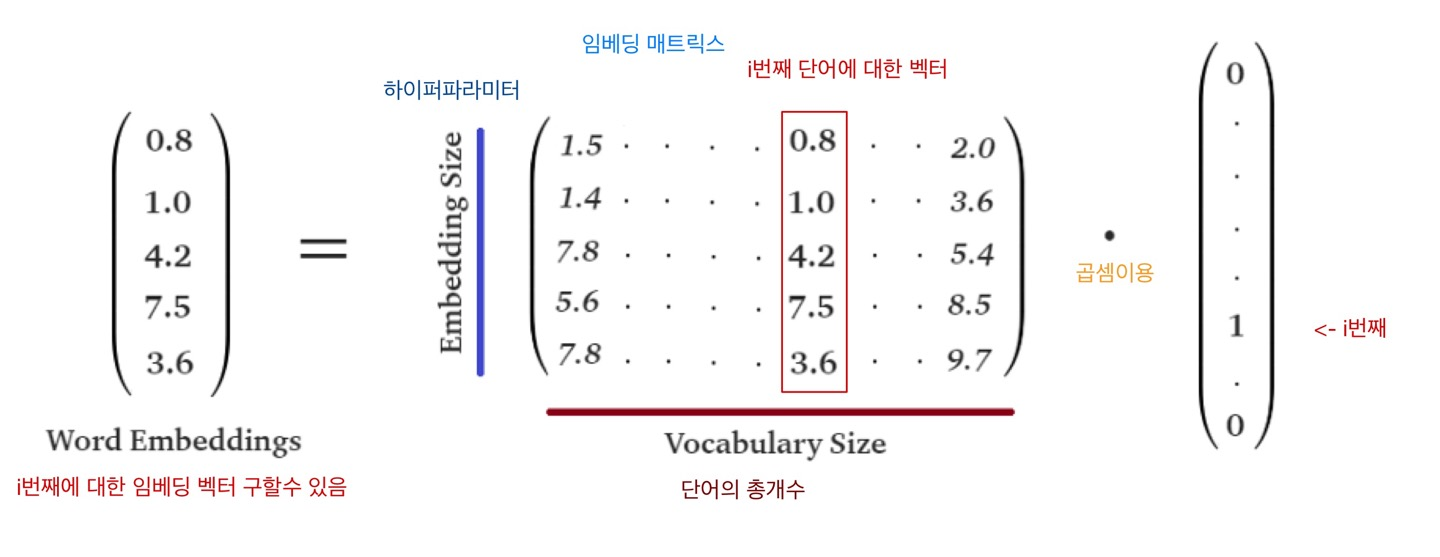

https://morioh.com/p/b5b47aa51746